In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8')

In [2]:
APPLICATION_PATH = 'data/application_samples.csv'
CREDIT_PATH = 'data/credit_features.csv'

application_df = pd.read_csv(APPLICATION_PATH)
credit_df = pd.read_csv(CREDIT_PATH)

print(application_df.shape)
print(credit_df.shape)

(8847, 7)
(8847, 14)


In [3]:
def preprocess_applications(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and engineer base application fields."""
    df = df.copy()
    df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], dayfirst=True)
    df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
    df['Term'] = pd.to_numeric(df['Term'], errors='coerce')
    df['Month'] = df['ApplicationDate'].dt.to_period('M').dt.to_timestamp()
    df['Quarter'] = df['ApplicationDate'].dt.to_period('Q').astype(str)
    df['SuccessLabel'] = df['Success'].map({1: 'Success', 0: 'Fail'})
    return df

application_df = preprocess_applications(application_df)

In [4]:
loan_purposes = [
    "Car",
    "Holiday",
    "Home improvements",
    "One off purchase",
    "Debt consolidation",
    "Paying off bills",
    "Wedding",
    "Medical expense",
    "Tuition",
    "Business",
    "Funeral",
    "Something else",
]

In [5]:
# Step 1: Lowercase and strip whitespace
application_df["LoanPurpose_clean"] = (
    application_df["LoanPurpose"]
    .astype(str)
    .str.strip()
    .str.lower()
)

raw_top5_names = (
    application_df["LoanPurpose_clean"]
        .value_counts()
        .head(5)
        .index
        .tolist()
)

# Step 2: Map to standardised categories using keyword matching
def standardize_loan_purpose(purpose):
    purpose = purpose.lower()
    
    # Debt consolidation variants
    if any(word in purpose for word in ['consolidat', 'debt']):
        return 'debt consolidation'
    
    # Home improvement variants
    if 'home' in purpose and 'improv' in purpose:
        return 'home improvement'
    
    # Add more mappings as needed:
    # if 'car' in purpose or 'vehicle' in purpose:
    #     return 'vehicle'
    # if 'wedding' in purpose:
    #     return 'wedding'
    
    # Keep as-is for unmatched
    return purpose

application_df["LoanPurpose_standardized"] = (
    application_df["LoanPurpose_clean"]
    .apply(standardize_loan_purpose)
)

In [6]:
# =============================================================================
# Semantic Similarity Mapping using FinBERT Embeddings
# =============================================================================
# Map unstructured LoanPurpose values to official Lendable categories
# using cosine similarity on FinBERT embeddings

from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from tqdm import tqdm

# -----------------------------------------------------------------------------
# 1. Load FinBERT model for embeddings (base model, not classification head)
# -----------------------------------------------------------------------------
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
finbert_model = AutoModel.from_pretrained(model_name)
finbert_model.eval()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finbert_model.to(device)
print(f"Using device: {device}")

# -----------------------------------------------------------------------------
# 2. Helper function to get embeddings (mean pooling over tokens)
# -----------------------------------------------------------------------------
def get_embeddings(texts, batch_size=32):
    """Generate FinBERT embeddings using mean pooling."""
    all_embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding"):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(
            batch, 
            return_tensors="pt", 
            padding=True, 
            truncation=True, 
            max_length=128
        ).to(device)
        
        with torch.no_grad():
            outputs = finbert_model(**inputs)
            # Mean pooling: average all token embeddings (excluding padding)
            attention_mask = inputs["attention_mask"].unsqueeze(-1)
            hidden_states = outputs.last_hidden_state
            masked_hidden = hidden_states * attention_mask
            summed = masked_hidden.sum(dim=1)
            counts = attention_mask.sum(dim=1)
            embeddings = summed / counts
            
        all_embeddings.append(embeddings.cpu())
    
    return torch.cat(all_embeddings, dim=0)

# -----------------------------------------------------------------------------
# 3. Get unique loan purposes from application_df
# -----------------------------------------------------------------------------
unique_purposes = application_df["LoanPurpose_clean"].dropna().unique().tolist()
print(f"Total unique loan purposes: {len(unique_purposes)}")

# -----------------------------------------------------------------------------
# 4. Generate embeddings for official categories and unique purposes
# -----------------------------------------------------------------------------
print("\nEncoding official Lendable categories...")
official_embeddings = get_embeddings(loan_purposes)

print("\nEncoding unique loan purposes from applications...")
purpose_embeddings = get_embeddings(unique_purposes)

# Normalise for cosine similarity
official_embeddings = F.normalize(official_embeddings, p=2, dim=1)
purpose_embeddings = F.normalize(purpose_embeddings, p=2, dim=1)

# -----------------------------------------------------------------------------
# 5. Compute cosine similarity and map to closest official category
# -----------------------------------------------------------------------------
# Similarity matrix: [num_unique_purposes x num_official_categories]
similarity_matrix = torch.mm(purpose_embeddings, official_embeddings.T)

# Get best match and score for each unique purpose
best_scores, best_indices = similarity_matrix.max(dim=1)

# Create mapping dictionary
purpose_mapping = {}
for i, raw_purpose in enumerate(unique_purposes):
    mapped_category = loan_purposes[best_indices[i].item()]
    confidence = best_scores[i].item()
    purpose_mapping[raw_purpose] = {
        "category": mapped_category,
        "confidence": confidence
    }

# -----------------------------------------------------------------------------
# 6. Create DataFrame to review mappings
# -----------------------------------------------------------------------------
mapping_df = pd.DataFrame([
    {
        "raw_purpose": k,
        "mapped_category": v["category"],
        "confidence": v["confidence"]
    }
    for k, v in purpose_mapping.items()
]).sort_values("confidence", ascending=False)

print(f"\n✅ Mapped {len(mapping_df)} unique purposes to {len(loan_purposes)} official categories")
print(f"\nConfidence score distribution:")
print(mapping_df["confidence"].describe())

# Preview high and low confidence mappings
print("\n--- Top 10 Highest Confidence Mappings ---")
display(mapping_df.head(10))

print("\n--- Top 10 Lowest Confidence Mappings (may need review) ---")
display(mapping_df.tail(10))


Using device: cpu
Total unique loan purposes: 2041

Encoding official Lendable categories...


Encoding: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]



Encoding unique loan purposes from applications...


Encoding: 100%|██████████| 64/64 [00:07<00:00,  8.59it/s]


✅ Mapped 2041 unique purposes to 12 official categories

Confidence score distribution:
count    2041.000000
mean        0.781579
std         0.096133
min         0.456552
25%         0.721287
50%         0.771996
75%         0.829884
max         1.000000
Name: confidence, dtype: float64

--- Top 10 Highest Confidence Mappings ---


,raw_purpose,mapped_category,confidence
662,holiday,Holiday,1.000000
231,debt consolidation,Debt consolidation,1.000000
2035,wedding,Wedding,1.000000
513,debt consolidation,Debt consolidation,1.000000
1591,something else,Something else,1.000000
4,car,Car,1.000000
82,càr,Car,1.000000
1221,tuition,Tuition,1.000000
677,home improvements,Home improvements,1.000000
1176,amplifier,Wedding,0.991656



--- Top 10 Lowest Confidence Mappings (may need review) ---


,raw_purpose,mapped_category,confidence
915,ill children,One off purchase,0.530401
1279,na spłatę samochodu,Home improvements,0.527956
1113,settle high apr finances,Paying off bills,0.518303
1553,unattractive credit card repayment,Paying off bills,0.515128
1388,flooded kitchen need repairs,One off purchase,0.511042
1829,unexpected short term expense,Paying off bills,0.510427
1739,credit card repayment with better interest rate,Paying off bills,0.504143
729,new home unforeseen expenses,One off purchase,0.495582
1914,major garden redesign due to wife's disability,One off purchase,0.469516
1909,unforeseen event,One off purchase,0.456552


Distribution of Mapped Loan Purposes (FinBERT)
LoanPurpose_finbert
Home improvements     2225
Car                   1639
Tuition               1249
Medical expense       1180
Debt consolidation     947
Business               724
Wedding                373
Paying off bills       174
Funeral                125
Holiday                 88
Something else          86
One off purchase        37
Name: count, dtype: int64


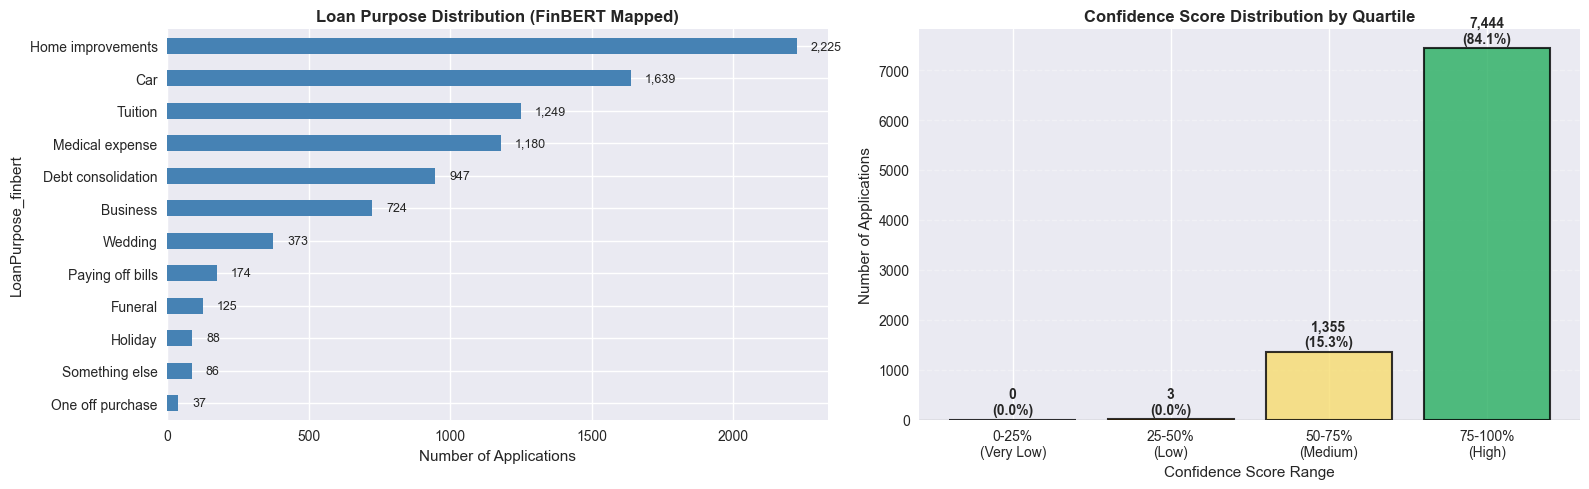


CONFIDENCE SCORE SUMMARY
✅ Above 50% confidence: 8,844 applications (100.0%)
⚠️  Below 50% confidence: 3 applications (0.0%)

Mean confidence: 0.894
Median confidence: 0.959


<Figure size 800x550 with 0 Axes>


⚠️ 3 applications (0.0%) have confidence < 0.5
Sample low-confidence mappings:


,LoanPurpose,LoanPurpose_clean,LoanPurpose_finbert,LoanPurpose_confidence
4921,New home unforeseen expenses,new home unforeseen expenses,One off purchase,0.495582
8446,Unforeseen event,unforeseen event,One off purchase,0.456552
8459,Major garden redesign due to Wife's disability,major garden redesign due to wife's disability,One off purchase,0.469516


In [7]:
# =============================================================================
# Apply Mapping to Full DataFrame
# =============================================================================

# Create simple lookup from raw purpose to mapped category
category_lookup = {k: v["category"] for k, v in purpose_mapping.items()}
confidence_lookup = {k: v["confidence"] for k, v in purpose_mapping.items()}

# Apply to application_df
application_df["LoanPurpose_finbert"] = application_df["LoanPurpose_clean"].map(category_lookup)
application_df["LoanPurpose_confidence"] = application_df["LoanPurpose_clean"].map(confidence_lookup)

# Show distribution of mapped categories
print("=" * 60)
print("Distribution of Mapped Loan Purposes (FinBERT)")
print("=" * 60)
mapped_dist = application_df["LoanPurpose_finbert"].value_counts()
print(mapped_dist)

# Visualise
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: Category distribution
mapped_dist.plot(kind="barh", ax=axes[0], color="steelblue")
axes[0].set_title("Loan Purpose Distribution (FinBERT Mapped)", fontweight="bold")
axes[0].set_xlabel("Number of Applications")
axes[0].invert_yaxis()
for i, v in enumerate(mapped_dist.values):
    axes[0].text(v + 50, i, f"{v:,}", va="center", fontsize=9)

# Right: Confidence score distribution by quartiles
# Create quartile bins
quartile_bins = [0, 0.25, 0.5, 0.75, 1.0]
quartile_labels = ['0-25%\n(Very Low)', '25-50%\n(Low)', '50-75%\n(Medium)', '75-100%\n(High)']
application_df['confidence_quartile'] = pd.cut(
    application_df['LoanPurpose_confidence'],
    bins=quartile_bins,
    labels=quartile_labels,
    include_lowest=True
)

# Count applications in each quartile
quartile_counts = application_df['confidence_quartile'].value_counts().sort_index()
quartile_pct = (quartile_counts / len(application_df) * 100).round(1)

# Color code: red for low confidence, yellow for medium, green for high
colors = ['#E74C3C', '#F39C12', '#F7DC6F', '#27AE60']

bars = axes[1].bar(
    range(len(quartile_counts)),
    quartile_counts.values,
    color=colors,
    edgecolor='black',
    linewidth=1.5,
    alpha=0.8
)

axes[1].set_xticks(range(len(quartile_counts)))
axes[1].set_xticklabels(quartile_labels, fontsize=10)
axes[1].set_title("Confidence Score Distribution by Quartile", fontweight="bold", fontsize=12)
axes[1].set_ylabel("Number of Applications", fontsize=11)
axes[1].set_xlabel("Confidence Score Range", fontsize=11)

# Add value labels on top of bars
for i, (count, pct) in enumerate(zip(quartile_counts.values, quartile_pct.values)):
    axes[1].text(
        i,
        count + 50,
        f"{count:,}\n({pct:.1f}%)",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Add threshold line at 50% confidence
axes[1].axhline(y=0, color='black', linewidth=0.8)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Summary statistics
below_50 = application_df[application_df['LoanPurpose_confidence'] < 0.5]
above_50 = application_df[application_df['LoanPurpose_confidence'] >= 0.5]

print("\n" + "=" * 70)
print("CONFIDENCE SCORE SUMMARY")
print("=" * 70)
print(f"✅ Above 50% confidence: {len(above_50):,} applications ({len(above_50)/len(application_df)*100:.1f}%)")
print(f"⚠️  Below 50% confidence: {len(below_50):,} applications ({len(below_50)/len(application_df)*100:.1f}%)")
print(f"\nMean confidence: {application_df['LoanPurpose_confidence'].mean():.3f}")
print(f"Median confidence: {application_df['LoanPurpose_confidence'].median():.3f}")

plt.tight_layout()
plt.show()

# Show low-confidence mappings that may need manual review
low_conf_threshold = 0.5
low_conf = application_df[application_df["LoanPurpose_confidence"] < low_conf_threshold]
print(f"\n⚠️ {len(low_conf)} applications ({len(low_conf)/len(application_df)*100:.1f}%) have confidence < {low_conf_threshold}")
print("Sample low-confidence mappings:")
display(
    low_conf[["LoanPurpose", "LoanPurpose_clean", "LoanPurpose_finbert", "LoanPurpose_confidence"]]
    .drop_duplicates(subset=["LoanPurpose_clean"])
    .head(15)
)


LOAN PURPOSE SUCCESS ANALYSIS (FinBERT Mapped Categories)
SuccessLabel         Fail  Success  Total  Success_Rate_%
LoanPurpose_finbert                                      
Home improvements    1996      229   2225           10.29
Car                  1465      174   1639           10.62
Tuition              1136      113   1249            9.05
Medical expense      1047      133   1180           11.27
Debt consolidation    856       91    947            9.61
Business              643       81    724           11.19
Wedding               335       38    373           10.19
Paying off bills      149       25    174           14.37
Funeral               109       16    125           12.80
Holiday                79        9     88           10.23
Something else         77        9     86           10.47
One off purchase       33        4     37           10.81


Overall Success Rate: 10.42%
Total Applications: 8,847
Total Successful: 922
Total Failed: 7,925


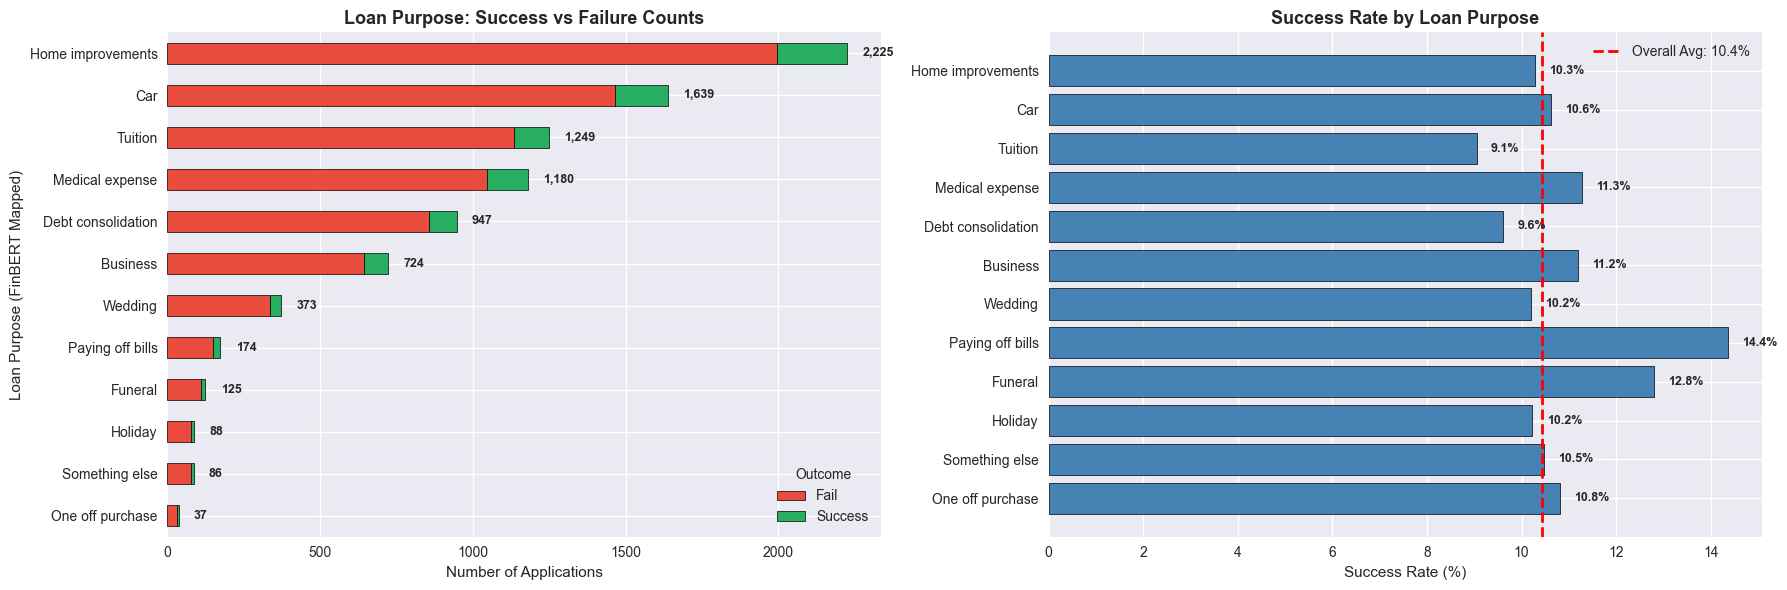


KEY INSIGHTS
✅ Highest Success Rate: Paying off bills (14.37%)
   → 25 successful out of 174 applications

❌ Lowest Success Rate: Tuition (9.05%)
   → 113 successful out of 1249 applications

📊 Highest Volume: Home improvements (2,225 applications)
   → Success rate: 10.29%

📈 Categories ABOVE average success rate: 7
   • Car: 10.62%
   • Medical expense: 11.27%
   • Business: 11.19%
   • Paying off bills: 14.37%
   • Funeral: 12.80%
   • Something else: 10.47%
   • One off purchase: 10.81%

📉 Categories BELOW average success rate: 5
   • Home improvements: 10.29%
   • Tuition: 9.05%
   • Debt consolidation: 9.61%
   • Wedding: 10.19%
   • Holiday: 10.23%


In [8]:
# =============================================================================
# Success vs Failure Analysis by Loan Purpose Category
# =============================================================================

# Group by loan purpose category and success status
purpose_success = (
    application_df.groupby(["LoanPurpose_finbert", "SuccessLabel"])["UID"]
    .count()
    .unstack(fill_value=0)
)

# Calculate totals and success rate
purpose_success["Total"] = purpose_success["Fail"] + purpose_success["Success"]
purpose_success["Success_Rate_%"] = (
    purpose_success["Success"] / purpose_success["Total"] * 100
).round(2)

# Sort by total volume (descending)
purpose_success = purpose_success.sort_values("Total", ascending=False)

print("=" * 80)
print("LOAN PURPOSE SUCCESS ANALYSIS (FinBERT Mapped Categories)")
print("=" * 80)
print(purpose_success)
print("\n")

# Calculate overall statistics
overall_success_rate = (
    application_df["Success"].sum() / len(application_df) * 100
)
print(f"Overall Success Rate: {overall_success_rate:.2f}%")
print(f"Total Applications: {len(application_df):,}")
print(f"Total Successful: {application_df['Success'].sum():,}")
print(f"Total Failed: {(application_df['Success'] == 0).sum():,}")

# =============================================================================
# Visualisation: Stacked Bar Chart with Labels
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Left axis: Absolute counts (stacked bar)
purpose_success[["Fail", "Success"]].plot(
    kind="barh",
    stacked=True,
    ax=axes[0],
    color=["#E74C3C", "#27AE60"],
    edgecolor="black",
    linewidth=0.5
)
axes[0].set_title(
    "Loan Purpose: Success vs Failure Counts",
    fontsize=13,
    fontweight="bold"
)
axes[0].set_xlabel("Number of Applications", fontsize=11)
axes[0].set_ylabel("Loan Purpose (FinBERT Mapped)", fontsize=11)
axes[0].legend(title="Outcome", loc="lower right")
axes[0].invert_yaxis()

# Add total count labels at the end of each bar
for i, (idx, row) in enumerate(purpose_success.iterrows()):
    total = row["Total"]
    axes[0].text(
        total + 50,
        i,
        f"{int(total):,}",
        va="center",
        fontsize=9,
        fontweight="bold"
    )

# Right axis: Success rate as horizontal bar chart (same order as left axis)
bars = axes[1].barh(
    range(len(purpose_success)),
    purpose_success["Success_Rate_%"],
    color="steelblue",
    edgecolor="black",
    linewidth=0.5
)
axes[1].set_yticks(range(len(purpose_success)))
axes[1].set_yticklabels(purpose_success.index)
axes[1].set_title(
    "Success Rate by Loan Purpose",
    fontsize=13,
    fontweight="bold"
)
axes[1].set_xlabel("Success Rate (%)", fontsize=11)
axes[1].axvline(
    x=overall_success_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Overall Avg: {overall_success_rate:.1f}%"
)
axes[1].legend()
axes[1].invert_yaxis()  # Match left axis order (top to bottom)

# Add percentage labels on bars
for i, (idx, row) in enumerate(purpose_success.iterrows()):
    rate = row["Success_Rate_%"]
    axes[1].text(
        rate + 0.3,
        i,
        f"{rate:.1f}%",
        va="center",
        fontsize=9,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

# =============================================================================
# Key Insights Table
# =============================================================================
print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)

# Highest success rate
highest_success = purpose_success.loc[purpose_success["Success_Rate_%"].idxmax()]
print(f"✅ Highest Success Rate: {highest_success.name} ({highest_success['Success_Rate_%']:.2f}%)")
print(f"   → {int(highest_success['Success'])} successful out of {int(highest_success['Total'])} applications")

# Lowest success rate
lowest_success = purpose_success.loc[purpose_success["Success_Rate_%"].idxmin()]
print(f"\n❌ Lowest Success Rate: {lowest_success.name} ({lowest_success['Success_Rate_%']:.2f}%)")
print(f"   → {int(lowest_success['Success'])} successful out of {int(lowest_success['Total'])} applications")

# Highest volume
highest_volume = purpose_success.loc[purpose_success["Total"].idxmax()]
print(f"\n📊 Highest Volume: {highest_volume.name} ({int(highest_volume['Total']):,} applications)")
print(f"   → Success rate: {highest_volume['Success_Rate_%']:.2f}%")

# Categories above/below average
above_avg = purpose_success[purpose_success["Success_Rate_%"] > overall_success_rate]
below_avg = purpose_success[purpose_success["Success_Rate_%"] < overall_success_rate]

print(f"\n📈 Categories ABOVE average success rate: {len(above_avg)}")
for cat in above_avg.index:
    rate = above_avg.loc[cat, "Success_Rate_%"]
    print(f"   • {cat}: {rate:.2f}%")

print(f"\n📉 Categories BELOW average success rate: {len(below_avg)}")
for cat in below_avg.index:
    rate = below_avg.loc[cat, "Success_Rate_%"]
    print(f"   • {cat}: {rate:.2f}%")
